In [1]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from operator import itemgetter
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegressionCV
pd.options.mode.use_inf_as_na = True

In [2]:
#read in our training features:
df = pd.read_csv('trainingfeats.csv')
display(df.shape)
df.head(1)

(7848, 48)

,object_id,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,...,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,-3.254554,-385.699911,-134.146566,-121.103501,-55.954592,-47.449847,-10.015225,-488.057968,-265.686005,...,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [3]:
#Filter to only galactic objects, which is the goal of this model
#per the code book, galactic objects have hostgal_specz == 0
egalmask = df['hostgal_specz'] != 0
egal = df[egalmask]
display(egal.shape)
#let's see our class imbalance
egal.groupby('target').agg('count')

(5523, 48)

,object_id,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,...,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
target,,,,,,,,,,,,,,,,,,,,,
15,495,495,495,495,495,495,495,495,495,495,...,495,495,495,495,495,495,495,495,495,495
42,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,...,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193
52,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
62,484,484,484,484,484,484,484,484,484,484,...,484,484,484,484,484,484,484,484,484,484
64,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
67,208,208,208,208,208,208,208,208,208,208,...,208,208,208,208,208,208,208,208,208,208
88,370,370,370,370,370,370,370,370,370,370,...,370,370,370,370,370,370,370,370,370,370
90,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
95,175,175,175,175,175,175,175,175,175,175,...,175,175,175,175,175,175,175,175,175,175


In [4]:
#Our classes are imbalanced and we'll need to Create SMOTE object
sm = SMOTE(sampling_strategy='not majority')

#Drop cols I don't want to generate with SMOTE. 
#Things like position in the sky or object_Id are meaningless to simulate with SMOTE
Y = egal['target']
#remove 'target' if using test data
X = egal.drop(['object_id','target', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'distmod'], axis=1) 

display(X.shape)
Y.shape

(5523, 40)

(5523,)

In [5]:
#confirm no nans
X.isnull().sum(axis=0).sum()


0

In [6]:
#Create extra samples and check how many were created
X_new, Y_new = sm.fit_resample(X,Y)
display(X_new.shape)

(20817, 40)

In [7]:
#Re-add target and confirm balance
df = pd.DataFrame(X_new, columns=X.columns)
df['target'] = Y_new
df.groupby('target').agg('count')

,mean_u,median_u,std_u,max_u,min_u,mean_g,median_g,std_g,max_g,min_g,...,errstd_u,errstd_g,errstd_r,errstd_i,errstd_z,errstd_Y,hostgal_specz,hostgal_photoz,hostgal_photoz_err,mwebv
target,,,,,,,,,,,,,,,,,,,,,
15,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
42,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
52,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
62,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
64,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
67,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
88,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
90,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
95,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313


# Lasso Regression for feature selection

In [8]:
lasso = LogisticRegressionCV(penalty='l1', Cs=1, cv=10, solver='liblinear', multi_class='auto', max_iter=200)
X = df.drop('target', axis=1)
Y = df['target']
lassfit = lasso.fit(X, Y)
print('\n Percentage accuracy lasso')
print(lassfit.score(X, Y))


 Percentage accuracy lasso
0.4419464860450593


In [9]:
#looks like this stores a coefficient for each target class/column combination
print([len(x) for x in lassfit.coef_])

[40, 40, 40, 40, 40, 40, 40, 40, 40]


In [10]:
#These are the features we can drop:
for i,y in enumerate(X.columns):
    if sum([x[i] for x in lassfit.coef_])==0:
        print(y+": ",[x[i] for x in lassfit.coef_])

median_u:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
std_u:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max_g:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_u:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_g:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_r:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_i:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_z:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errstd_Y:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_specz:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_photoz:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
hostgal_photoz_err:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mwebv:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
#These we should keep:
featnames =[]
for i,y in enumerate(X.columns):
    if sum([x[i] for x in lassfit.coef_])!=0:
        print(y+": ",[x[i] for x in lassfit.coef_])
        featnames.append(y)

mean_u:  [0.01214352045864304, -0.009271964367283742, 0.0, 0.0, 0.0, 0.0, 0.016324324792178383, 0.0, 0.0]
max_u:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005586782821332944]
min_u:  [-0.017058333496675966, 0.0, 0.0, 0.0, -0.01430142141393519, 0.0, 0.0, 0.0, 0.0]
mean_g:  [0.0, 0.0, -0.01268095630992972, 0.0, -0.043797672786570034, 0.0, 0.0, -0.008557648728000116, 0.008594757803760553]
median_g:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.026149805239087724]
std_g:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029690514339578963, 0.0, 0.0]
min_g:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007797530584549811, 0.0, 0.0]
mean_r:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020538509936408423, 0.0, 0.0]
median_r:  [0.0, -0.009073678128874963, 0.0, -0.0024467740161869885, 0.0, 0.0, 0.008670968331276294, -0.0009800893983120112, 0.0]
std_r:  [0.002860520118029925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max_r:  [0.0, 0.0, -0.0002296990769748993, 0.0, 0.0, 0.0, 0.0, -0.0006064278472851509, 0.0]
min_r:  [0.0, 0.0, 0.0, 0.0

In [12]:
#Store the feats that are nonzero coefficients:
X2 = X[featnames]
display(X2.shape)
X2.head()

(20817, 27)

,mean_u,max_u,min_u,mean_g,median_g,std_g,min_g,mean_r,median_r,std_r,...,mean_z,median_z,std_z,max_z,min_z,mean_Y,median_Y,std_Y,max_Y,min_Y
0,-2.720398,-0.986966,-0.900262,-1.794175,-3.096805,-0.561735,-0.073896,-0.792176,-2.463012,7.113509,...,10.529041,11.330316,9.827934,14.770886,-14.735178,-11.715749,-10.067919,-12.394593,-12.286801,-14.211164
1,-0.048080,3.236164,4.308728,4.539396,0.024093,0.171336,0.660403,1.004354,2.542647,1.828872,...,20.994711,33.572102,41.159981,47.310059,-3.459960,-3.393080,-2.848838,-5.435799,-5.836310,-19.159811
2,1.797523,14.412924,13.134436,10.746138,1.056714,0.888115,1.361369,1.270151,2.749555,4.374445,...,220.795212,203.250702,183.633118,141.513290,-3.874349,-3.618410,-2.159753,-4.944036,-15.494463,-10.249387
3,0.660948,11.086555,9.906102,6.896742,0.581027,1.154596,1.014106,1.745012,1.973272,2.360084,...,106.671692,139.818405,143.600189,109.157585,-6.804703,-2.622109,-2.084535,-2.800270,-16.543753,-10.860540
4,14.888847,33.614120,25.112238,21.894274,0.361674,0.552879,0.098578,0.819691,-1.263775,52.335031,...,1289.851440,1002.724548,737.409363,653.044312,-7.049055,-3.504384,-3.254089,-3.270371,-5.226799,-13.854152


In [88]:
X2.columns

Index(['mean_u', 'max_u', 'min_u', 'mean_g', 'median_g', 'std_g', 'min_g',
       'mean_r', 'median_r', 'std_r', 'max_r', 'min_r', 'mean_i', 'median_i',
       'std_i', 'max_i', 'min_i', 'mean_z', 'median_z', 'std_z', 'max_z',
       'min_z', 'mean_Y', 'median_Y', 'std_Y', 'max_Y', 'min_Y'],
      dtype='object')

# KNN with lasso-chosen features

In [13]:
#test a KNN

#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    X2, Y, test_size=0.5)



egalknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
egalknn.fit(egalX_train, egalY_train)

scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
display(scores)
scores.mean()

array([0.84578544, 0.85823755, 0.85043145, 0.85508637, 0.86935639,
       0.85302594, 0.84326923, 0.86814244, 0.86608863, 0.84860174])

0.8558025176489696

In [18]:
#check more values for n_neighbors:
for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())
    

2 0.886715597688649
3 0.8624167186234851
4 0.8574118683173925
5 0.8472284522579507
6 0.8425150200150231
7 0.8345401683215276
8 0.8285857783920927
9 0.8221501522630673


In [19]:
#try without weighting

for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n)
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())

2 0.8545359952564444
3 0.8353266842022871
4 0.821970595404505
5 0.8050507846455256
6 0.7930339237342272
7 0.7814082535192887
8 0.7742007950430911
9 0.76373185686757


In [14]:
#2 neighbors seem to be best with distance weighting
egalknn = KNeighborsClassifier(n_neighbors=2, weights='distance')
egalknn.fit(egalX_train, egalY_train)

scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
display(scores)
scores.mean()

array([0.87164751, 0.89655172, 0.89165868, 0.88579655, 0.89048991,
       0.88856868, 0.875     , 0.89124158, 0.89306358, 0.87849566])

0.8862513876033162

Counter({88: 2313, 42: 2313, 90: 2313, 67: 2313, 95: 2313, 62: 2313, 15: 2313, 52: 2313, 64: 2313})


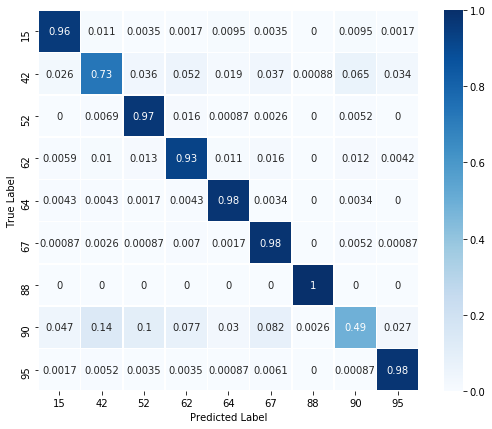

In [21]:
counts = Counter(df['target'])
egalLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

srt = sorted(egalLabels)
egalY_pred = egalknn.predict(egalX_test)
print(counts)
cm = confusion_matrix(egalY_test, egalY_pred,labels = srt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=srt,xticklabels=srt, cmap='Blues',annot = True, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [42]:
#generate probability of all classes for each object.
#Classes will be the column titles:
cols = sorted(Y.unique())

#This df should have a row for each object and a column for each class. 
#the data are class probabilites and each row sums to 1 (100%)
orderprobs = pd.DataFrame(egalknn.predict_proba(egalX_test), columns=cols)
orderprobs['max_value'] = orderprobs.max(axis=1)
#This variable is the 'unknown' threshold. If no probabilities are over this threshold, 
#the object will get assigned to the unknown class, 99.
thresh = .51

#if an object is getting assigned to class 99, this is the confidence level to give class 99.
#all other classes will be scaled proportionately down from their original values so the row sums to 1 (100%)
confidence99 = .75

orderprobs[99] = np.where(orderprobs.max_value <= thresh,confidence99,0)
#Don't need the max value column anymore
orderprobs = orderprobs.drop('max_value', axis=1)

#loop through the columns, scaling down values for rows where class 99 is nonzero.
for col in cols:
    orderprobs[col] = orderprobs[col]*(1-orderprobs[99])

    
print(orderprobs.head(20).sum(axis=1).mean()) #This should be 1.0 if everything worked.
print(orderprobs.head(20).sum(axis=1).std()) #This should be 0.0 if everything worked.

1.0
0.0


In [43]:
#How many objects got class 99?
orderprobs.astype(bool).sum(axis=0)

15    1347
42    1295
52    1486
62    1473
64    1317
67    1465
88    1173
90     986
95    1321
99     293
dtype: int64

# Try SVM

In [44]:
from sklearn.svm import SVC

In [45]:
#commented out to prevent accidental runs, since it took forever
#svc = SVC(gamma='auto')

#svc.fit(egalX_train,egalY_train)
#cross_val_score(svc, egalX_test, egalY_test, cv=5)
#>> array([0.36864813, 0.37763916, 0.38184438, 0.37277537, 0.3705486 ])

array([0.36864813, 0.37763916, 0.38184438, 0.37277537, 0.3705486 ])

# Try KNN with scaling

In [62]:
egalscaler = StandardScaler().fit(X2)
X3 = pd.DataFrame(egalscaler.transform(X2), columns=X2.columns)
print(X3.shape)
X3.head()

(20817, 27)


,mean_u,max_u,min_u,mean_g,median_g,std_g,min_g,mean_r,median_r,std_r,...,mean_z,median_z,std_z,max_z,min_z,mean_Y,median_Y,std_Y,max_Y,min_Y
0,-0.092520,-0.158087,-0.166866,-0.200308,-0.099238,-0.057355,-0.078844,-0.102244,-0.127584,-0.090150,...,-0.184586,-0.220052,-0.241612,-0.268510,0.042898,-0.002543,0.055931,0.085687,0.248002,0.565777
1,-0.079892,-0.136096,-0.137484,-0.158309,-0.053107,-0.046021,-0.068585,-0.078050,-0.073138,-0.102229,...,-0.174698,-0.196317,-0.208121,-0.230461,0.091749,0.123240,0.171924,0.188941,0.333201,0.506669
2,-0.071172,-0.077894,-0.087700,-0.117151,-0.037843,-0.034939,-0.058792,-0.074470,-0.070888,-0.096411,...,0.014071,-0.015251,-0.055834,-0.120306,0.089953,0.119835,0.182996,0.196237,0.205635,0.613097
3,-0.076542,-0.095216,-0.105910,-0.142677,-0.044875,-0.030819,-0.063644,-0.068075,-0.079331,-0.101015,...,-0.093752,-0.082940,-0.098624,-0.158140,0.077257,0.134892,0.184204,0.228046,0.191776,0.605798
4,-0.009312,0.022094,-0.020137,-0.043227,-0.048117,-0.040122,-0.076434,-0.080537,-0.114540,0.013209,...,1.024104,0.837877,0.536090,0.477843,0.076199,0.121558,0.165413,0.221071,0.341252,0.570041


In [63]:
#test a KNN

#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    X3, Y, test_size=0.5)



egalknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
egalknn.fit(egalX_train, egalY_train)

scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
display(scores)
scores.mean()

array([0.80993314, 0.81957774, 0.81381958, 0.82821497, 0.8125    ,
       0.80288462, 0.80865385, 0.81039461, 0.80365736, 0.79961464])

0.8109250504515215

In [64]:
#check more values for n_neighbors:
for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())
    

2 0.847626351854452
3 0.8297599884814142
4 0.8202477498049816
5 0.8109250504515215
6 0.8043957741766408
7 0.7992089764878465
8 0.7936350878606764
9 0.7889328299003002


In [65]:
#try without weighting

for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n)
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())

2 0.8138056348946886
3 0.8004596186655272
4 0.780767736611862
5 0.7675076110300558
6 0.75444325420821
7 0.7427280191677816
8 0.7330225394044456
9 0.7275533612751032


# PCA to reduce

In [75]:
Xt = X3.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
listcomps = eig_val_cov / sum(eig_val_cov)
sum(listcomps[0:9])

0.9884388615876948

In [76]:
#We have 9 classes and can retain 98% of our information with 9 components, let's try that

In [77]:
pcaX = pd.DataFrame(index=X.index)
for i in range(0,9):
    P = eig_vec_cov[:, i]
    featureP = P.T.dot(Xt)
    pcaX[i] = featureP
pcaX

,0,1,2,3,4,5,6,7,8
0,-0.682935,0.300074,-0.424878,-0.154990,0.166231,0.040798,0.328132,-0.252102,0.080614
1,-0.595184,0.461724,-0.492614,-0.125724,0.121755,0.003951,0.219744,-0.167262,0.069755
2,-0.269825,0.386436,-0.518174,-0.080091,0.010219,0.145353,0.208096,-0.248332,0.099411
3,-0.416323,0.430503,-0.502909,-0.105228,0.023716,0.060921,0.218332,-0.212250,0.092209
4,1.416952,-0.129399,-0.838593,0.042278,-0.393505,1.002312,-0.135166,-0.585442,-0.029306
5,-0.630381,0.491290,-0.486040,-0.135368,0.145610,0.001975,0.271629,-0.193065,0.090409
6,-0.130219,0.349224,-0.509591,-0.058843,-0.014942,0.172857,0.272106,-0.188706,0.095147
7,-0.632697,0.478042,-0.496494,-0.144562,0.158349,0.021626,0.221069,-0.179467,0.063345
8,-0.269558,0.358156,-0.536881,-0.117348,0.056353,0.070638,0.219177,-0.226732,0.065125
9,-0.619634,0.481383,-0.475845,-0.133759,0.145103,-0.002182,0.225757,-0.156180,0.080875


# KNN with PCA

In [78]:
#test a KNN

#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    pcaX, Y, test_size=0.5)



egalknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
egalknn.fit(egalX_train, egalY_train)

scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
display(scores)
scores.mean()

array([0.77948226, 0.78044104, 0.76510067, 0.76605944, 0.76199616,
       0.78386167, 0.75792507, 0.77115385, 0.75818882, 0.7942029 ])

0.7718411887342705

In [79]:
#check more values for n_neighbors:
for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())
    

2 0.8031540540109828
3 0.7880748352571672
4 0.7787584048880692
5 0.7718411887342705
6 0.7657861454969955
7 0.7564629453586159
8 0.7517501587460249
9 0.7481004561220452


In [80]:
#try without weighting

for n in range(2,10):
    egalknn = KNeighborsClassifier(n_neighbors=n)
    egalknn.fit(egalX_train, egalY_train)

    scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
    print(n,scores.mean())

2 0.7628067241590818
3 0.7523317110553533
4 0.7331161840388171
5 0.7163046654671072
6 0.7077520010123166
7 0.6957452782579614
8 0.6878646657776452
9 0.6808478794171003


In [81]:
#that was not effective. Here's what I'll use

#  The original KNN with 2 neighbors:

In [82]:
#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    X2, Y, test_size=0.5)

egalknn = KNeighborsClassifier(n_neighbors=2, weights='distance')
egalknn.fit(egalX_train, egalY_train)

scores = cross_val_score(egalknn,egalX_test,egalY_test, cv=10)
display(scores)
scores.mean()

array([0.87177033, 0.87835249, 0.89932886, 0.87236084, 0.87127762,
       0.88856868, 0.89423077, 0.8960539 , 0.88331726, 0.87945998])

0.8834720739826837

Counter({88: 2313, 42: 2313, 90: 2313, 67: 2313, 95: 2313, 62: 2313, 15: 2313, 52: 2313, 64: 2313})


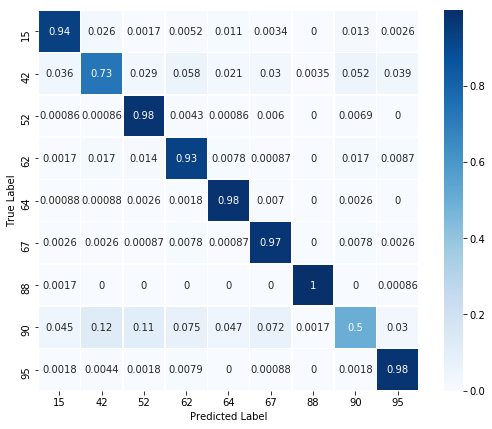

In [83]:
counts = Counter(df['target'])
egalLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

srt = sorted(egalLabels)
egalY_pred = egalknn.predict(egalX_test)
print(counts)
cm = confusion_matrix(egalY_test, egalY_pred,labels = srt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=srt,xticklabels=srt, cmap='Blues',annot = True, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [84]:
#generate probability of all classes for each object.
#Classes will be the column titles:
cols = sorted(Y.unique())

#This df should have a row for each object and a column for each class. 
#the data are class probabilites and each row sums to 1 (100%)
orderprobs = pd.DataFrame(egalknn.predict_proba(egalX_test), columns=cols)
orderprobs['max_value'] = orderprobs.max(axis=1)
#This variable is the 'unknown' threshold. If no probabilities are over this threshold, 
#the object will get assigned to the unknown class, 99.
thresh = .51

#if an object is getting assigned to class 99, this is the confidence level to give class 99.
#all other classes will be scaled proportionately down from their original values so the row sums to 1 (100%)
confidence99 = .75

orderprobs[99] = np.where(orderprobs.max_value <= thresh,confidence99,0)
#Don't need the max value column anymore
orderprobs = orderprobs.drop('max_value', axis=1)

#loop through the columns, scaling down values for rows where class 99 is nonzero.
for col in cols:
    orderprobs[col] = orderprobs[col]*(1-orderprobs[99])

    
print(orderprobs.head(20).sum(axis=1).mean()) #This should be 1.0 if everything worked.
print(orderprobs.head(20).sum(axis=1).std()) #This should be 0.0 if everything worked.

1.0
0.0


In [85]:
#How many objects got class 99?
orderprobs.astype(bool).sum(axis=0)

15    1344
42    1306
52    1522
62    1478
64    1319
67    1430
88    1172
90     992
95    1325
99     327
dtype: int64